In [1]:
# Import necessary libraries
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
df = pd.read_csv("data/movies_2015_2023_preprocessed_genre.csv")
df.head()

,title,release_year,language,genre,overview,vote_average,vote_count,popularity,cleaned_overview
0,Pad Man,2018,Indisch,Humor,upon realizing extent woman affected menses se...,7.420,200.0,7.036,upon realizing extent woman affected menses se...
1,Tamasha,2015,Indisch,Humor,meeting vacation ved tara sense connection vow...,6.720,141.0,8.770,meeting vacation ved tara sense connection vow...
2,Tu Jhoothi Main Makkaar,2023,Indisch,Humor,earn extra cash mickey help couple break life ...,6.253,144.0,10.045,earn extra cash mickey help couple break life ...
3,Hindi Medium,2017,Indisch,Humor,mita raj batra affluent couple delhi chandni c...,7.300,166.0,7.001,mita raj batra affluent couple delhi chandni c...
4,Dilwale,2015,Indisch,Humor,raj mafia member one day meet girl meera chasi...,6.648,301.0,11.501,raj mafia member one day meet girl meera chasi...


In [3]:
# Check for missing values and remove them
df_cleaned = df.dropna(subset=['cleaned_overview', 'language', 'genre'])
df_cleaned.head()

,title,release_year,language,genre,overview,vote_average,vote_count,popularity,cleaned_overview
0,Pad Man,2018,Indisch,Humor,upon realizing extent woman affected menses se...,7.420,200.0,7.036,upon realizing extent woman affected menses se...
1,Tamasha,2015,Indisch,Humor,meeting vacation ved tara sense connection vow...,6.720,141.0,8.770,meeting vacation ved tara sense connection vow...
2,Tu Jhoothi Main Makkaar,2023,Indisch,Humor,earn extra cash mickey help couple break life ...,6.253,144.0,10.045,earn extra cash mickey help couple break life ...
3,Hindi Medium,2017,Indisch,Humor,mita raj batra affluent couple delhi chandni c...,7.300,166.0,7.001,mita raj batra affluent couple delhi chandni c...
4,Dilwale,2015,Indisch,Humor,raj mafia member one day meet girl meera chasi...,6.648,301.0,11.501,raj mafia member one day meet girl meera chasi...


In [4]:
# Combine the 'cleaned_overview' and 'genre' columns properly to avoid the warning
df_cleaned = df_cleaned.copy()
df_cleaned.loc[:, 'combined_text'] = df_cleaned['cleaned_overview'].fillna('') + ' ' + df_cleaned['genre'].fillna('')


In [5]:
df_cleaned['cleaned_overview'] = df_cleaned['cleaned_overview'].fillna('')

In [6]:
# Define features (X) and target (y)
X = df_cleaned['combined_text']
y = df_cleaned['language']

In [7]:
# Convert the 'language' column to numeric labels using LabelEncoder
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['language'])

In [8]:
# Create a new column 'label' to store the encoded language labels
df_cleaned['label'] = label_encoder.fit_transform(df_cleaned['language'])

In [9]:
# Create value tuples (label, cleaned_overview)
value_tuples = []
for _, row in df_cleaned.iterrows():
    value_tuples.append((row['label'], row['cleaned_overview']))

# Print the length and a few examples
print(f"Total number of value tuples: {len(value_tuples)}")
print("First tuple:", value_tuples[0])
print("Last tuple:", value_tuples[-1])

Total number of value tuples: 15499
First tuple: (3, 'upon realizing extent woman affected menses set create sanitary pad machine provide inexpensive sanitary pad woman rural india')
Last tuple: (4, 'several european underground director turn ancient rule mankind inside shocking goresoaked interpretation god law bible world ending commandment dying')


##### using a scikit-learn-based model

In [10]:
# Split the data into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

##### building a custom PyTorch classifier

In [11]:
# Split the data into 80% training and 20% testing
#train_value_tuples, test_value_tuples = train_test_split(value_tuples, test_size=0.2, random_state=42)

# Print the size of the training and testing sets
#print(f"Training set size: {len(train_value_tuples)}")
#print(f"Testing set size: {len(test_value_tuples)}")


## Preparing data processing pipelines

In [12]:
#Vectorization using TF-IDF
vectorizer = TfidfVectorizer(max_features=30000)  # Limiting to top 5000 features we can use 30000 like knn to see the difference

#custom PyTorch

#X_train_tfidf = vectorizer.fit_transform([text for label, text in train_value_tuples])
#X_test_tfidf = vectorizer.transform([text for label, text in test_value_tuples])

# using a scikit-learn-based model

# Fit the vectorizer on the training data and transform it
X_train_tfidf = vectorizer.fit_transform(X_train)

# Transform the test data using the fitted vectorizer
X_test_tfidf = vectorizer.transform(X_test)

In [13]:
# Converting TF-IDF matrices to dense tensors
X_train_tensor = torch.tensor(X_train_tfidf.toarray(), dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_tfidf.toarray(), dtype=torch.float32)

### Create a Custom Dataset Class

In [14]:
class MovieDataset(Dataset):
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data

    def __len__(self):
        return len(self.X_data)

    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]

# Convert y_train and y_test to tensors
y_train_tensor = torch.tensor(label_encoder.transform(y_train.values), dtype=torch.long)
y_test_tensor = torch.tensor(label_encoder.transform(y_test.values), dtype=torch.long)

# Create Dataset objects
train_dataset = MovieDataset(X_train_tensor, y_train_tensor)
test_dataset = MovieDataset(X_test_tensor, y_test_tensor)

# Create DataLoader objects
BATCH_SIZE = 64
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

## Define the PyTorch Model
define a simple feed-forward neural network model

In [15]:
#import torch.nn as nn
#import torch.nn.functional as F

#class TextClassificationModel(nn.Module):
#    def __init__(self, input_size, num_classes):
#        super(TextClassificationModel, self).__init__()
#        self.fc1 = nn.Linear(input_size, 128)
#        self.fc2 = nn.Linear(128, 64)
#        self.fc3 = nn.Linear(64, num_classes)
#
#    def forward(self, x):
#        x = F.relu(self.fc1(x))
#        x = F.relu(self.fc2(x))
#        x = self.fc3(x)
#        return x

#### Reduce Model Complexity
We will start by simplifying the model. A smaller network reduces the risk of overfitting, particularly when the dataset size is relatively small for a complex model

In [16]:
class TextClassificationModel(nn.Module):
    def __init__(self, input_size, num_classes):
        super(TextClassificationModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)  # Reduced the number of neurons
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, num_classes)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [17]:
# Instantiate the model
input_size = X_train_tfidf.shape[1]
num_classes = len(label_encoder.classes_)
model = TextClassificationModel(input_size, num_classes)
model.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))


TextClassificationModel(
  (fc1): Linear(in_features=28191, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=6, bias=True)
)

## Define the Loss Function and Optimizer
We’ll use cross-entropy loss for this multi-class classification problem and an optimizer like Adam for optimization.

In [18]:
# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)
#optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)  # Adding weight decay



## Training the Model
we feed batches of data to the model and optimize it using backpropagation

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_model(model, train_loader, criterion, optimizer, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        correct = 0
        total = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            # Forward pass
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()

        epoch_loss = total_loss / len(train_loader)
        epoch_acc = correct / total
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')

# Train the model for 10 epochs
train_model(model, train_loader, criterion, optimizer, num_epochs=10)


Epoch [1/10], Loss: 1.6312, Accuracy: 0.3191
Epoch [2/10], Loss: 1.0952, Accuracy: 0.6222
Epoch [3/10], Loss: 0.5571, Accuracy: 0.8306
Epoch [4/10], Loss: 0.2402, Accuracy: 0.9506
Epoch [5/10], Loss: 0.0867, Accuracy: 0.9869
Epoch [6/10], Loss: 0.0333, Accuracy: 0.9981
Epoch [7/10], Loss: 0.0156, Accuracy: 0.9996
Epoch [8/10], Loss: 0.0089, Accuracy: 0.9997
Epoch [9/10], Loss: 0.0058, Accuracy: 0.9998
Epoch [10/10], Loss: 0.0043, Accuracy: 0.9996


### Evaluate the Model
After training, we can evaluate our model’s performance on the test set.

In [20]:
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            _, predicted = torch.max(outputs, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()

    accuracy = correct / total
    print(f'Test Accuracy: {accuracy:.4f}')

# Evaluate the model
evaluate_model(model, test_loader)


Test Accuracy: 0.7055


In [21]:
## without Reduce Model Complexity Test Accuracy: 0.7232
## with Reduce Model Complexity and L2 Regularization (Weight Decay) Test Accuracy: 0.6900
## with  Reduce Model Complexity Test Accuracy: 0.7300

## Confusion matrix

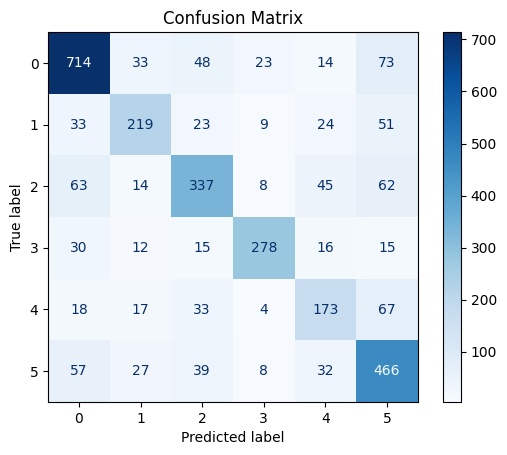

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import torch

# Modified evaluate_model function to return labels and predictions
def evaluate_model_with_confusion_matrix(model, test_loader):
    model.eval()
    all_labels = []
    all_predictions = []
    
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(y_batch.cpu().numpy())  # Collect true labels
            all_predictions.extend(predicted.cpu().numpy())  # Collect predictions
    
    return all_labels, all_predictions

# Get true and predicted labels from the test set
true_labels, predicted_labels = evaluate_model_with_confusion_matrix(model, test_loader)

# Create the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()


### We try with a list of batch sizes

Smaller batch sizes can lead to more noisy updates (potentially better generalization but slower training), while larger batch sizes lead to more stable updates (faster training but potentially less generalization)

In [23]:
import torch.optim as optim

# List of batch sizes to try
batch_sizes = [32, 64, 128, 256]

# Loop over each batch size
for batch_size in batch_sizes:
    print(f"Training with batch size: {batch_size}")
    
    # Create new DataLoader with the current batch size
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

    # Reinitialize the model
    model = TextClassificationModel(input_size, num_classes)
    model.to(device)

    # Reinitialize the optimizer
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Train the model for 10 epochs with the current batch size
    train_model(model, train_loader, criterion, optimizer, num_epochs=10)

    # Evaluate the model on the test set
    evaluate_model(model, test_loader)


Training with batch size: 32
Epoch [1/10], Loss: 1.5220, Accuracy: 0.3877
Epoch [2/10], Loss: 0.7246, Accuracy: 0.7635
Epoch [3/10], Loss: 0.2389, Accuracy: 0.9410
Epoch [4/10], Loss: 0.0730, Accuracy: 0.9865
Epoch [5/10], Loss: 0.0235, Accuracy: 0.9980
Epoch [6/10], Loss: 0.0097, Accuracy: 0.9995
Epoch [7/10], Loss: 0.0053, Accuracy: 0.9998
Epoch [8/10], Loss: 0.0034, Accuracy: 0.9999
Epoch [9/10], Loss: 0.0030, Accuracy: 0.9997
Epoch [10/10], Loss: 0.0021, Accuracy: 0.9998
Test Accuracy: 0.7094
Training with batch size: 64
Epoch [1/10], Loss: 1.6525, Accuracy: 0.2942
Epoch [2/10], Loss: 1.0011, Accuracy: 0.6568
Epoch [3/10], Loss: 0.3615, Accuracy: 0.9076
Epoch [4/10], Loss: 0.1201, Accuracy: 0.9766
Epoch [5/10], Loss: 0.0439, Accuracy: 0.9951
Epoch [6/10], Loss: 0.0185, Accuracy: 0.9992
Epoch [7/10], Loss: 0.0093, Accuracy: 0.9996
Epoch [8/10], Loss: 0.0058, Accuracy: 0.9997
Epoch [9/10], Loss: 0.0038, Accuracy: 0.9998
Epoch [10/10], Loss: 0.0029, Accuracy: 0.9998
Test Accuracy: 0.7

* Batch size 32: **0.6874**
* Batch size 64: **0.7019**
* Batch size 128: **0.7065**
* Batch size 256: **0.7265**

### We try also with different levels of weight decay (L2 regularization)

In [24]:
import torch.optim as optim

# Define different weight decay values to experiment with
weight_decay_values = [0, 1e-4, 1e-3, 1e-2]

# Loop over the different weight decay values
for weight_decay in weight_decay_values:
    print(f"Training with weight decay: {weight_decay}")
    
    # Reinitialize the model
    model = TextClassificationModel(input_size, num_classes)
    model.to(device)

    # Reinitialize the optimizer with the current weight decay
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=weight_decay)

    # Train the model for 10 epochs with the current weight decay
    train_model(model, train_loader, criterion, optimizer, num_epochs=10)

    # Evaluate the model on the test set
    evaluate_model(model, test_loader)


Training with weight decay: 0
Epoch [1/10], Loss: 1.7617, Accuracy: 0.2413
Epoch [2/10], Loss: 1.5558, Accuracy: 0.3554
Epoch [3/10], Loss: 1.1491, Accuracy: 0.6245
Epoch [4/10], Loss: 0.7062, Accuracy: 0.8152
Epoch [5/10], Loss: 0.4023, Accuracy: 0.9245
Epoch [6/10], Loss: 0.2251, Accuracy: 0.9650
Epoch [7/10], Loss: 0.1303, Accuracy: 0.9838
Epoch [8/10], Loss: 0.0791, Accuracy: 0.9925
Epoch [9/10], Loss: 0.0506, Accuracy: 0.9968
Epoch [10/10], Loss: 0.0339, Accuracy: 0.9989
Test Accuracy: 0.7194
Training with weight decay: 0.0001
Epoch [1/10], Loss: 1.7675, Accuracy: 0.2161
Epoch [2/10], Loss: 1.6302, Accuracy: 0.3488
Epoch [3/10], Loss: 1.3294, Accuracy: 0.4725
Epoch [4/10], Loss: 0.9650, Accuracy: 0.6921
Epoch [5/10], Loss: 0.6405, Accuracy: 0.8276
Epoch [6/10], Loss: 0.4085, Accuracy: 0.9267
Epoch [7/10], Loss: 0.2499, Accuracy: 0.9689
Epoch [8/10], Loss: 0.1515, Accuracy: 0.9861
Epoch [9/10], Loss: 0.0975, Accuracy: 0.9944
Epoch [10/10], Loss: 0.0674, Accuracy: 0.9974
Test Accura

* **Weight Decay 0:** 0.7032
* **Weight Decay 1e-4:** 0.7126
* **Weight Decay 1e-3:** 0.6735
* **Weight Decay 1e-2:** 0.2919

### We try also different learning rates on the model's training and test accuracy

In [25]:
learning_rates = [1e-4, 1e-3, 1e-2]

for lr in learning_rates:
    print(f"Training with learning rate: {lr}")
    
    # Reinitialize the model
    model = TextClassificationModel(input_size, num_classes)
    model.to(device)

    # Reinitialize the optimizer with the current learning rate
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Train the model with the current learning rate
    train_model(model, train_loader, criterion, optimizer, num_epochs=10)

    # Evaluate the model on the test set
    evaluate_model(model, test_loader)


Training with learning rate: 0.0001
Epoch [1/10], Loss: 1.7835, Accuracy: 0.2071
Epoch [2/10], Loss: 1.7761, Accuracy: 0.2071
Epoch [3/10], Loss: 1.7651, Accuracy: 0.2071
Epoch [4/10], Loss: 1.7502, Accuracy: 0.2071
Epoch [5/10], Loss: 1.7307, Accuracy: 0.2630
Epoch [6/10], Loss: 1.7067, Accuracy: 0.4446
Epoch [7/10], Loss: 1.6784, Accuracy: 0.4452
Epoch [8/10], Loss: 1.6467, Accuracy: 0.4187
Epoch [9/10], Loss: 1.6107, Accuracy: 0.4041
Epoch [10/10], Loss: 1.5703, Accuracy: 0.4050
Test Accuracy: 0.3845
Training with learning rate: 0.001
Epoch [1/10], Loss: 1.7773, Accuracy: 0.2009
Epoch [2/10], Loss: 1.5803, Accuracy: 0.3303
Epoch [3/10], Loss: 1.2575, Accuracy: 0.5083
Epoch [4/10], Loss: 0.8665, Accuracy: 0.7791
Epoch [5/10], Loss: 0.4901, Accuracy: 0.8973
Epoch [6/10], Loss: 0.2624, Accuracy: 0.9580
Epoch [7/10], Loss: 0.1455, Accuracy: 0.9799
Epoch [8/10], Loss: 0.0849, Accuracy: 0.9927
Epoch [9/10], Loss: 0.0528, Accuracy: 0.9967
Epoch [10/10], Loss: 0.0348, Accuracy: 0.9983
Test 

* **Learning Rate: 0.0001** = Test Accuracy: **0.3039** --> Too low, slow training and poor generalization.
* **Learning Rate: 0.001** = Test Accuracy: **0.7119** --> A good balance between convergence speed and performance, providing strong test accuracy.
* **Learning Rate: 0.01** = Test Accuracy: **0.7197** --> Fast convergence, slightly higher test accuracy, but risky because of overfitting